In [3]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm  
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
  
import cv2
import dill as pickle
import warnings
warnings.filterwarnings('ignore')

In [17]:
# device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.is_built_with_cuda()
print(tf.version.VERSION)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17180343115950675549
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6298796032
locality {
  bus_id: 1
  links {
  }
}
incarnation: 382505013655700363
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:09:00.0, compute capability: 7.5"
]
2.6.0


In [18]:
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0 # training: 80% data, validation: 20% data
                 )
  

In [19]:
#Path for training and testing directory
train_path ='Y:/Rafiq/Research/ML/DatasetSorted/train'
test_path = 'Y:/Rafiq/Research/ML/DatasetSorted/val'
img_width = 150
img_height = 150
batchsize = 32
root = pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['0 Standard', '1 Dowels', '10 Round', '11 Round tube', '12 T', '13 U', '14 Z', '15 Steel', '16 Flat', '17 HEA', '18 IPE', '19 L', '2 Nut', '20 Square', '21 Square tube', '22 Rectangle tube', '23 Round', '24 Round tube', '25 T', '26 U', '27 Hat profile', '28 BU2 Profile', '29 ECO holder', '3 Washer', '30 F Profile', '31 KH 35   SZ 20', '32 NBK holder', '33 UBE NG', '34 Corners', '35 Accessories', '36 Tekofix profile', '37 Alkapo profile', '38 L Profile', '39 HWB consoles', '4 Aluminium', '40 Agraffe profile', '41 System UBE', '42 System UBEKA', '43 Targo UBE', '44 T wall bracket', '45 Thermal stop US and T', '46 Thermal stop', '47 U Alho profile', '48 U Profile', '49 WB', '5 Flat', '6 L', '7 Square', '8 Square tube', '9 Rectangle tube']


In [20]:
# training_data = []
# IMG_SIZE = 50
# CATEGORIES = classes
# DATADIR = train_path

# def create_training_data():
#     for category in CATEGORIES: 

#         path = os.path.join(DATADIR,category)  
#         class_num = CATEGORIES.index(category)  

#         for img in tqdm(os.listdir(path)):  
#             try:
#                 img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
#                 new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
#                 training_data.append([new_array, class_num])  # add this to our training_data
#             except Exception as e:  # in the interest in keeping the output clean...
#                 pass
#             #except OSError as e:
#             #    print("OSErrroBad img most likely", e, os.path.join(path,img))
#             #except Exception as e:
#             #    print("general exception", e, os.path.join(path,img))
            
# create_training_data()

# print(len(training_data))

In [21]:
train_generator = gen.flow_from_directory(
    train_path, # images data path / folder in which images are there
    target_size=(img_width,img_height),    
    batch_size = batchsize,
    color_mode='rgb',
    class_mode = 'categorical'
)
  
  
validation_generator = gen.flow_from_directory(
    test_path, # images data path / folder in which images are there
    target_size= (img_width,img_height),    
    batch_size = batchsize,
    color_mode='rgb',
    class_mode = 'categorical'
)

Found 7102 images belonging to 50 classes.
Found 2011 images belonging to 50 classes.


In [22]:

x,y = next(train_generator)
x.shape


(32, 150, 150, 3)

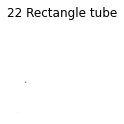

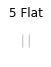

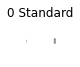

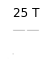

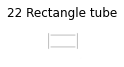

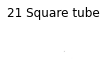

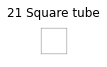

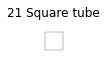

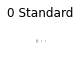

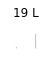

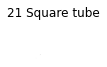

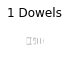

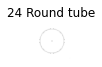

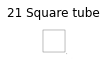

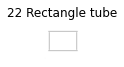

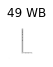

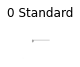

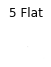

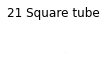

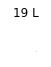

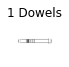

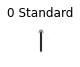

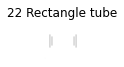

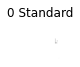

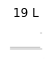

In [23]:

a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list
  
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
        
        plt.show()  
        
plot_images(x,y)


# Building Model

In [24]:
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(150,150,3)
                     )
  
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
  
model = tf.keras.Sequential([ 
        base_model,   
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(50, activation='softmax')
    ])

In [25]:

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
batch_normalization_203 (Bat (None, 3, 3, 1536)        10752     
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

In [27]:

early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [28]:

batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

# fit model
history = model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = validation_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early])

221
62
Epoch 1/25
221/221 [==============================] - 130s 499ms/step - loss: 1.7967 - accuracy: 0.5207 - val_loss: 1.2153 - val_accuracy: 0.6366
Epoch 2/25
221/221 [==============================] - 101s 455ms/step - loss: 1.3080 - accuracy: 0.6273 - val_loss: 1.0417 - val_accuracy: 0.6915
Epoch 3/25
221/221 [==============================] - 100s 453ms/step - loss: 1.1477 - accuracy: 0.6587 - val_loss: 0.9708 - val_accuracy: 0.7092
Epoch 4/25
221/221 [==============================] - 100s 451ms/step - loss: 1.0320 - accuracy: 0.6902 - val_loss: 0.8847 - val_accuracy: 0.7036
Epoch 5/25
221/221 [==============================] - 100s 453ms/step - loss: 0.9820 - accuracy: 0.7010 - val_loss: 0.8298 - val_accuracy: 0.7258
Epoch 6/25
221/221 [==============================] - 101s 458ms/step - loss: 0.9038 - accuracy: 0.7239 - val_loss: 0.8189 - val_accuracy: 0.7500
Epoch 7/25
221/221 [==============================] - 100s 453ms/step - loss: 0.8529 - accuracy: 0.7364 - val_loss: 0

In [55]:
# model.save_weights("HH.h5")
# model.save("my_model")
filepath = 'saved_model'
tf.keras.models.save_model(model, filepath,save_format='h5')

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy:0.8066478371620178\nValidation Accuracy: 0.8140121102333069')

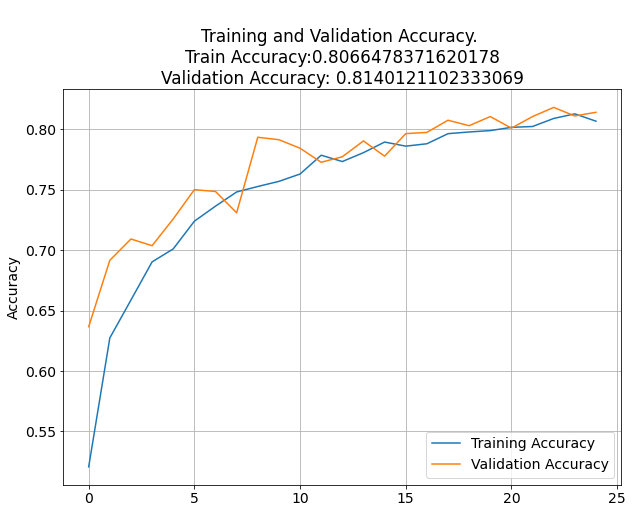

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy:{str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

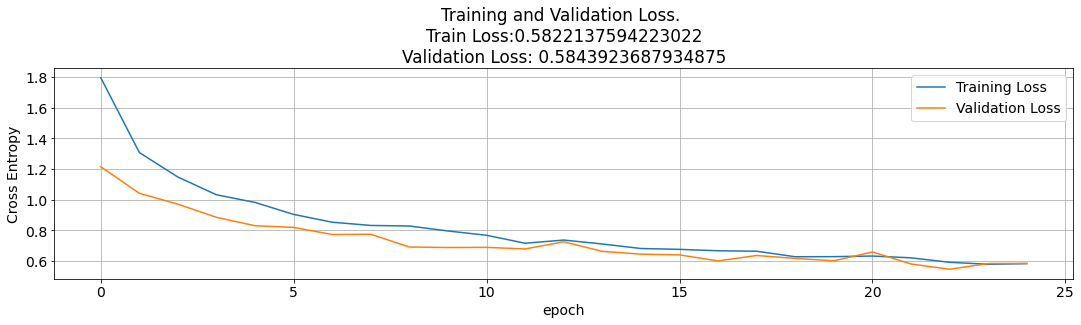

In [33]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [34]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 
  
print("Loss: ",accuracy_score[0])

63/63 [==============================] - 23s 361ms/step - loss: 0.5916 - accuracy: 0.8135
[0.5915741324424744, 0.8135256171226501]
Accuracy: 81.3526%
Loss:  0.5915741324424744


[[[249 248 248]
  [243 242 242]
  [243 242 242]
  ...
  [243 242 242]
  [243 242 242]
  [243 242 242]]

 [[249 248 248]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [243 242 242]]

 [[249 248 248]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [243 242 242]]

 ...

 [[249 248 248]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [243 242 242]]

 [[249 248 248]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [243 242 242]]

 [[255 255 255]
  [249 248 248]
  [249 248 248]
  ...
  [249 248 248]
  [249 248 248]
  [249 248 248]]]


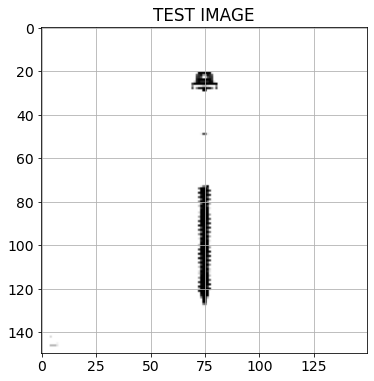

In [48]:

test_img_path = 'c021c51c-3e72-316b-9b0c-f847eea6135b.jpg'
  
img = cv2.imread(test_img_path)
print(img)
resized_img = cv2.resize(img, (150, 150)).reshape(-1, 150, 150, 3)/255
  
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [4]:
pickle_out= open("model_trained.p", "wb")
pickle.dump(model,pickle_out)
pickle_out.close()

NameError: name 'model' is not defined